In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from wasserstein_loss import wasserstein_generator_loss, wasserstein_discriminator_loss
from tabular_wgan_gp import tabularWGANGP
from tabular_discriminator import build_discriminator
from tabular_generator import build_generator

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Building the model

In [3]:
latent_dim = 32
out_shape = 14
num_classes = 2

In [4]:
generator = build_generator(latent_dim = latent_dim, num_classes = num_classes, out_shape = out_shape, layers_dim=[128,256,512,1024])

In [5]:
discriminator = build_discriminator(out_shape = out_shape, num_classes = num_classes, layers_dim=[1024,512,256,128])

In [6]:
model = tabularWGANGP(generator, discriminator, latent_dim = latent_dim, out_shape = out_shape)
model.compile(    
    discriminator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    generator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    discriminator_loss = wasserstein_discriminator_loss,
    generator_loss = wasserstein_generator_loss
)

## Reading and preprocessing the data

In [7]:
df = pd.read_csv('data/original/adult.csv')

In [8]:
# encode categorical features into numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital.status','occupation','relationship','race','sex','native.country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

In [9]:
from sklearn.model_selection import train_test_split
y = df["income"].values
X = df.drop(["income"],1)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training the model

In [10]:
# setting up constants
epochs = 100
batch_size = 32

In [11]:
y_train = keras.utils.to_categorical(y_train,num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [12]:
model.fit(dataset, epochs = epochs, batch_size = batch_size)

Epoch 1/100
814/814 [==============================] - 28s 28ms/step - g_loss: 2.5715 - d_loss: -1.3982
Epoch 2/100
814/814 [==============================] - 22s 28ms/step - g_loss: 2.4308 - d_loss: -2.1241
Epoch 3/100
814/814 [==============================] - 22s 27ms/step - g_loss: 1.2452 - d_loss: -2.0110
Epoch 4/100
814/814 [==============================] - 22s 27ms/step - g_loss: 2.1201 - d_loss: -1.9411
Epoch 5/100
814/814 [==============================] - 22s 27ms/step - g_loss: 2.6382 - d_loss: -1.9220
Epoch 6/100
814/814 [==============================] - 21s 26ms/step - g_loss: 3.1930 - d_loss: -1.9131
Epoch 7/100
814/814 [==============================] - 22s 27ms/step - g_loss: 2.8611 - d_loss: -1.9016
Epoch 8/100
814/814 [==============================] - 21s 26ms/step - g_loss: 2.4095 - d_loss: -1.8887
Epoch 9/100
814/814 [==============================] - 21s 25ms/step - g_loss: 1.9602 - d_loss: -1.8753
Epoch 10/100
814/814 [==============================] - 23s 29ms

## Evaluating the results

In [13]:
y_train = np.argmax(y_train, axis = -1)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4914
           1       0.74      0.60      0.67      1599

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



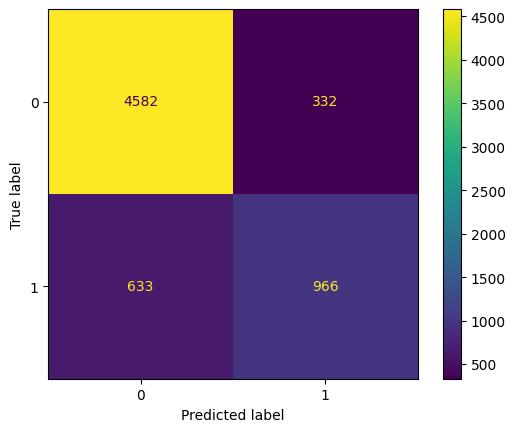

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# first train a random forest classifier on the original data
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [15]:
df["income"].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [16]:
# generate data using trained model
noise = np.random.normal(0, 1, (19758, latent_dim))
sampled_labels = np.zeros(19758).reshape(-1, 1)
sampled_labels = keras.utils.to_categorical(sampled_labels,num_classes)

gen_samples = model.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('income',1).columns)

noise_2 = np.random.normal(0, 1, (6290, latent_dim))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)
sampled_labels_2 = keras.utils.to_categorical(sampled_labels_2,num_classes)

gen_samples_2 = model.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('income',1).columns)

gen_df_2['income'] = 1
gen_df['income']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('income', 1)
y_train_2 = df_gan['income'].values

197/197 [==============================] - 0s 1ms/step


In [17]:
X_train_2.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,-0.941807,-1.000000,-0.087818,0.080896,-0.481967,1.000000,0.998662,0.999816,0.358296,0.683299,-0.115222,-0.131176,0.112616,0.280662
1,-0.543369,0.910350,-0.424639,0.981711,-0.070000,0.923901,-0.576539,0.563525,0.425418,0.706740,-0.163073,-0.209873,0.044521,0.302889
2,-0.997179,0.016898,0.036995,-0.942984,-0.824928,1.000000,0.260965,0.968199,0.451757,-1.000000,-0.142986,-0.196052,-1.000000,0.299437
3,-0.013556,0.223485,0.285632,0.241423,-0.624011,-0.393304,-0.571030,-0.809469,0.235193,0.686667,0.151308,0.165920,0.112126,-1.000000
4,0.999183,0.066304,0.987239,0.956626,-0.134689,-0.818936,0.233652,-0.228997,0.412224,-0.999999,-0.134331,-0.161099,-0.999408,0.298009


              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4914
           1       0.64      0.60      0.62      1599

    accuracy                           0.82      6513
   macro avg       0.76      0.75      0.75      6513
weighted avg       0.82      0.82      0.82      6513



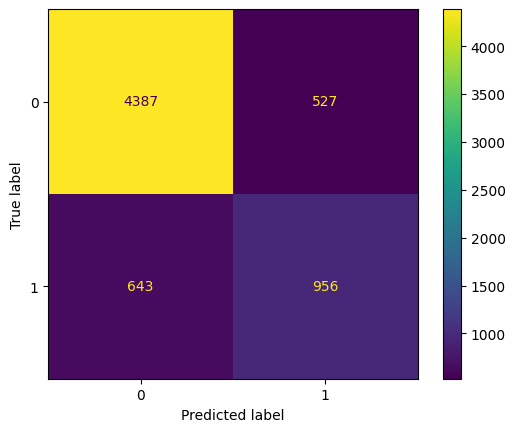

In [18]:
# now train a different instance of random forest classifier with the same parameters on generated data
rf1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf1.fit(X_train_2,y_train_2)

y_pred = rf1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf1, X_test, y_test)
plt.show()

## Distance measurement for generated data

In [19]:
generated = scaler.inverse_transform(df_gan.drop(["income"],1))
generated_df = pd.DataFrame(data=generated,columns = df.drop('income',1).columns)
generated_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,25.735189,2.412955,180509.312500,10.611292,8.840733,4.118035,10.795873,3.052813,3.969976,0.990697,226.711838,34.446064,41.827957,38.914669
1,31.169968,5.194305,144958.437500,14.097631,9.900592,4.003415,4.134676,2.351804,4.026950,1.001726,-126.676476,2.734540,40.987171,39.088570
2,24.979904,3.893495,193683.109375,6.648668,7.958403,4.118035,7.676305,3.002012,4.049305,0.198706,21.670572,8.303937,28.090216,39.061558
3,38.396736,4.194272,219926.343750,11.232565,8.475300,2.019443,4.157972,0.145750,3.865488,0.992282,2195.082520,154.162079,41.821907,28.895205
4,52.210724,3.965427,293979.812500,14.000548,9.734168,1.378356,7.560804,1.078422,4.015750,0.198707,85.592445,22.388172,28.097528,39.050388


In [20]:
print(generated_df.mean())
print(generated_df.std())

age                   37.744720
workclass              3.956367
fnlwgt            186558.953125
education             10.583974
education.num         10.177630
marital.status         2.650270
occupation             6.633686
relationship           1.179376
race                   3.828619
sex                    0.753138
capital.gain         548.093445
capital.loss          29.221390
hours.per.week        40.827816
native.country        38.041714
dtype: float32
age                   9.727076
workclass             0.806290
fnlwgt            71742.070312
education             2.514513
education.num         1.805182
marital.status        1.171983
occupation            3.353681
relationship          1.264050
race                  0.419756
sex                   0.370785
capital.gain       1882.750000
capital.loss        105.154671
hours.per.week        7.076140
native.country        2.953638
dtype: float32


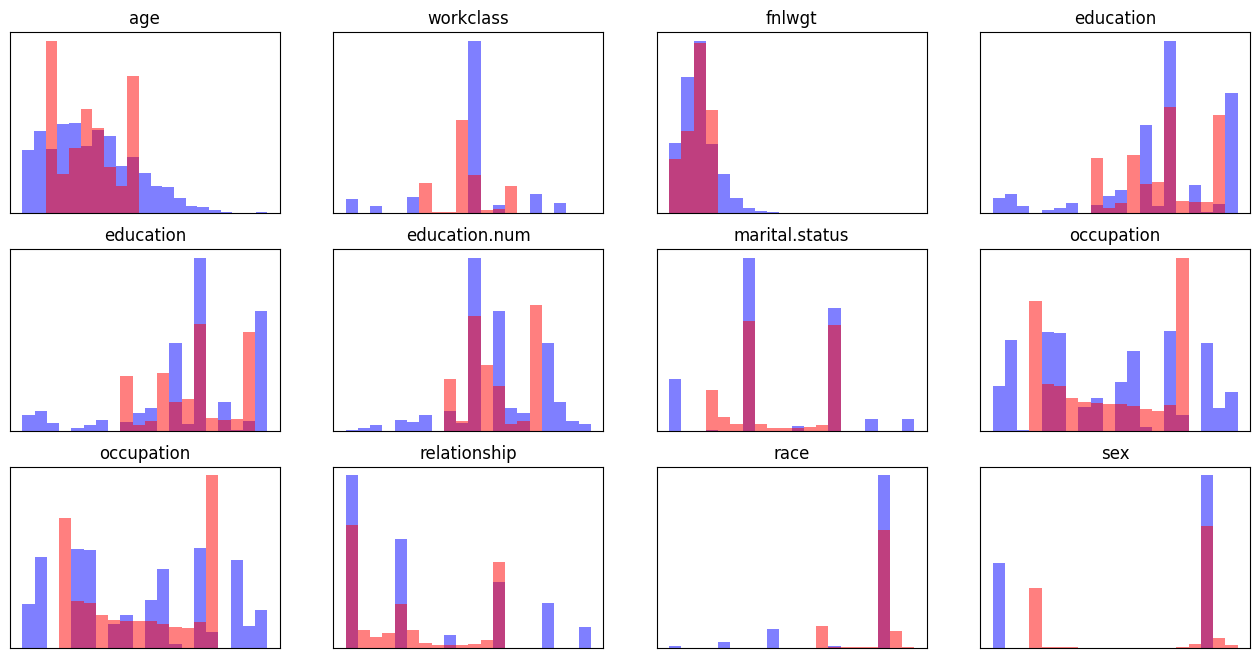

In [21]:
from utils import build_hist
build_hist(df,generated_df,3,4,df.columns[:12],figsize=(16,8))